# Question 3

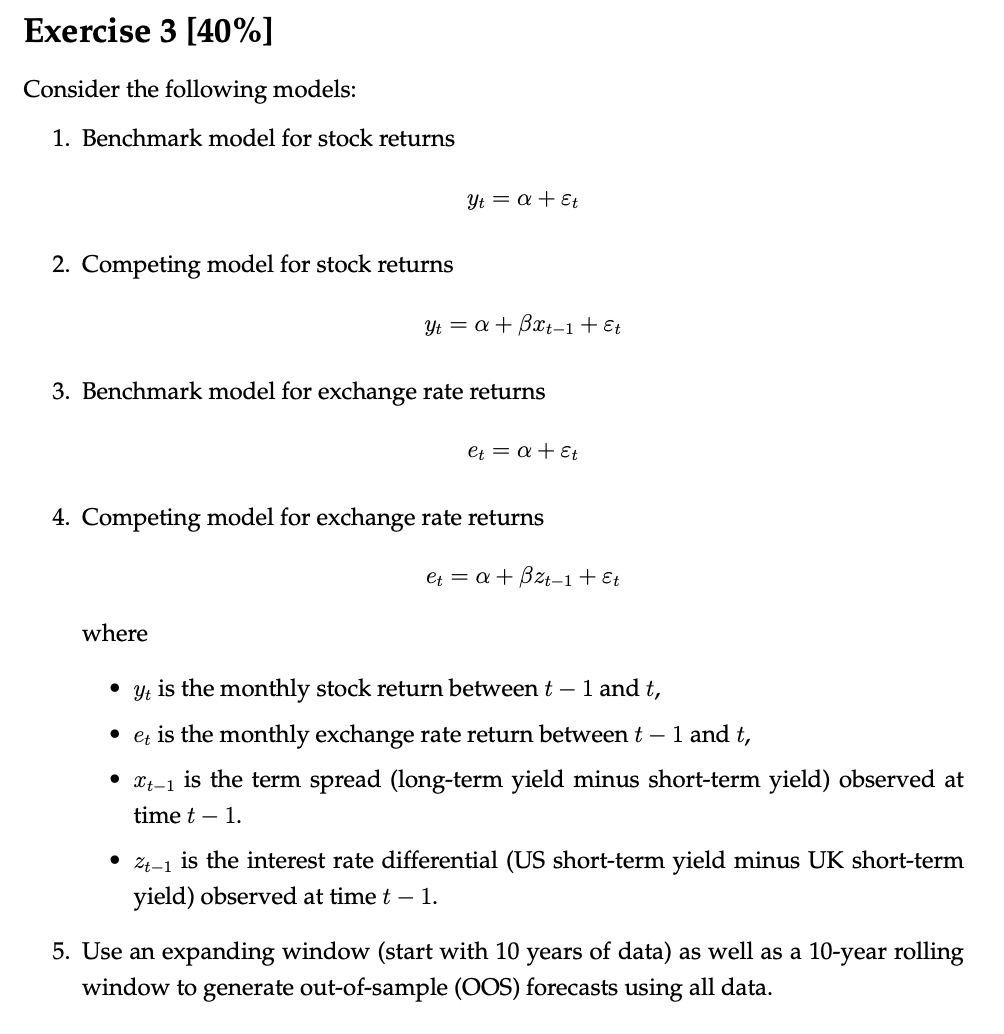

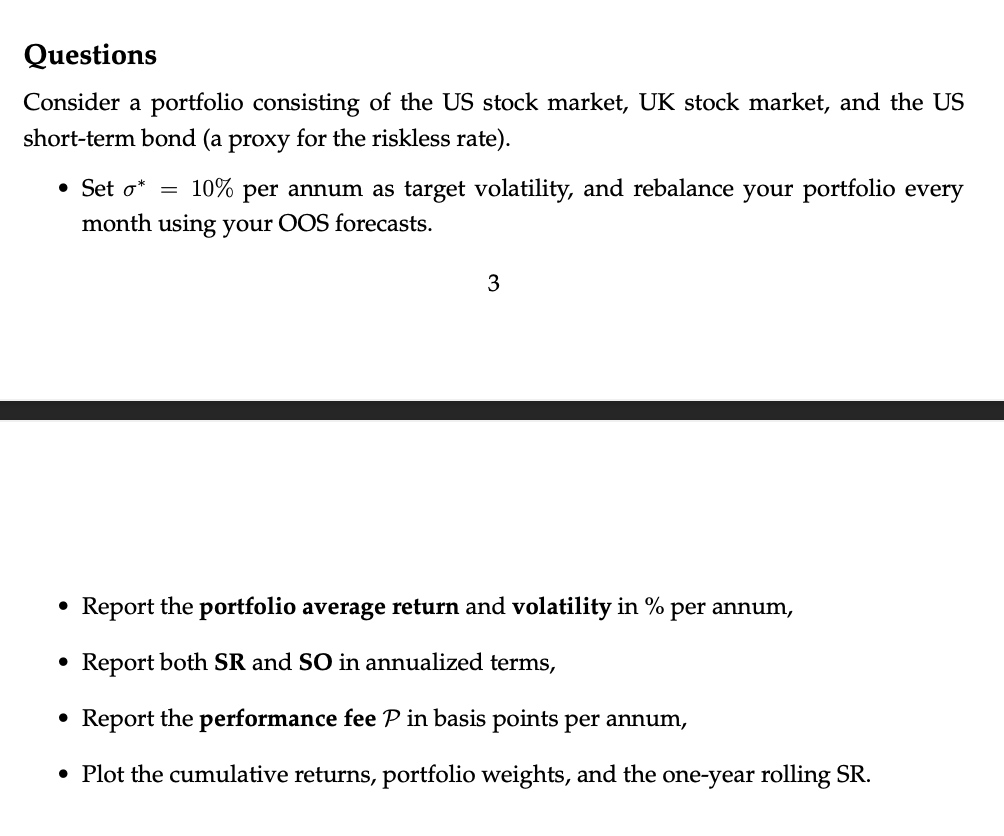

# Import Data

In [120]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 
import statsmodels.api as sm 
from datetime import datetime as dt
import yfinance as yf
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [121]:
us_data_path = '/Users/talhajamal/Documents/Documents/Imperial/Courses/Semester 2/Empirical Finance/IndividualProject/coursework_1/Data_coursework_1.xlsx'
us_data = pd.read_excel(us_data_path, sheet_name='US')
us_data['Date'] = pd.to_datetime(us_data['Date'], dayfirst=True)
us_data["Log Returns"] = np.log(us_data['Stock Index'] / us_data['Stock Index'].shift(1))
us_data['Term Spread'] = us_data['Long-term Yield'].shift(1) - us_data['Short-term Yield'].shift(1)
us_data['Risk Free Returns'] =  (1 + us_data["Short-term Yield"]/100) ** (1/12) - 1

us_data.dropna(inplace=True)
us_data.reset_index(drop = True, inplace=True)
us_data

,Date,Stock Index,Short-term Yield,Long-term Yield,Log Returns,Term Spread,Risk Free Returns
0,1792-02-29,2.496140,4.198,4.198,0.060760,0.00,0.003433
1,1792-03-31,2.297596,4.940,4.940,-0.082882,0.00,0.004026
2,1792-04-30,2.350072,5.143,5.143,0.022583,0.00,0.004188
3,1792-05-31,2.562141,4.557,4.557,0.086397,0.00,0.003720
4,1792-06-30,2.512370,4.675,4.675,-0.019617,0.00,0.003815
...,...,...,...,...,...,...,...
2779,2023-09-30,4507.660000,5.550,4.590,-0.017875,-1.47,0.004511
2780,2023-10-31,4288.050000,5.590,4.880,-0.049946,-0.96,0.004543
2781,2023-11-30,4193.800000,5.450,4.370,-0.022225,-0.71,0.004432
2782,2023-12-31,4567.800000,5.400,3.880,0.085424,-1.08,0.004392


In [122]:
# UK Data
uk_data_path = '/Users/talhajamal/Documents/Documents/Imperial/Courses/Semester 2/Empirical Finance/IndividualProject/coursework_1/Data_coursework_1.xlsx'
uk_data = pd.read_excel(uk_data_path, sheet_name='UK')
uk_data['Date'] = pd.to_datetime(uk_data['Date'], dayfirst=True)
uk_data["Log Returns"] = np.log(uk_data['Stock Index'] / uk_data['Stock Index'].shift(1))
uk_data["FX Returns"] = np.log(uk_data['FX rate'] / uk_data['FX rate'].shift(1))
uk_data['Term Spread'] = uk_data['Long-term Yield'].shift(1) - uk_data['Short-term Yield'].shift(1)
uk_data['Interest Rate Differential'] = us_data['Short-term Yield'].shift(1) - uk_data['Short-term Yield'].shift(1)

uk_data.dropna(inplace=True)
uk_data.reset_index(drop = True, inplace=True)

uk_data

,Date,Stock Index,Short-term Yield,Long-term Yield,FX rate,Log Returns,FX Returns,Term Spread,Interest Rate Differential
0,1792-02-29,10.842223,3.800,3.121,4.5620,0.050124,0.007260,-0.607,0.378
1,1792-03-31,10.952050,3.790,3.109,4.1169,0.010079,-0.102661,-0.679,1.140
2,1792-04-30,10.451244,3.790,3.230,4.3215,-0.046806,0.048502,-0.681,1.353
3,1792-05-31,10.358707,3.800,3.213,4.1615,-0.008894,-0.037727,-0.560,0.767
4,1792-06-30,10.403753,3.800,3.235,4.5106,0.004339,0.080555,-0.587,0.875
...,...,...,...,...,...,...,...,...,...
2778,2023-08-31,4059.530000,5.531,4.360,1.2673,-0.033546,-0.012858,-1.139,0.113
2779,2023-09-30,4127.240000,5.389,4.447,1.2197,0.016542,-0.038284,-1.171,0.019
2780,2023-10-31,3954.350000,5.338,4.518,1.2152,-0.042793,-0.003696,-0.942,0.201
2781,2023-11-30,4053.800000,5.323,4.176,1.2622,0.024838,0.037948,-0.820,0.112


In [123]:
uk_data

,Date,Stock Index,Short-term Yield,Long-term Yield,FX rate,Log Returns,FX Returns,Term Spread,Interest Rate Differential
0,1792-02-29,10.842223,3.800,3.121,4.5620,0.050124,0.007260,-0.607,0.378
1,1792-03-31,10.952050,3.790,3.109,4.1169,0.010079,-0.102661,-0.679,1.140
2,1792-04-30,10.451244,3.790,3.230,4.3215,-0.046806,0.048502,-0.681,1.353
3,1792-05-31,10.358707,3.800,3.213,4.1615,-0.008894,-0.037727,-0.560,0.767
4,1792-06-30,10.403753,3.800,3.235,4.5106,0.004339,0.080555,-0.587,0.875
...,...,...,...,...,...,...,...,...,...
2778,2023-08-31,4059.530000,5.531,4.360,1.2673,-0.033546,-0.012858,-1.139,0.113
2779,2023-09-30,4127.240000,5.389,4.447,1.2197,0.016542,-0.038284,-1.171,0.019
2780,2023-10-31,3954.350000,5.338,4.518,1.2152,-0.042793,-0.003696,-0.942,0.201
2781,2023-11-30,4053.800000,5.323,4.176,1.2622,0.024838,0.037948,-0.820,0.112


In [124]:
us_data = us_data.drop(us_data.index[-1])

In [125]:
us_data.tail()

,Date,Stock Index,Short-term Yield,Long-term Yield,Log Returns,Term Spread,Risk Free Returns
2778,2023-08-31,4588.96,5.56,4.09,0.030664,-1.58,0.004519
2779,2023-09-30,4507.66,5.55,4.59,-0.017875,-1.47,0.004511
2780,2023-10-31,4288.05,5.59,4.88,-0.049946,-0.96,0.004543
2781,2023-11-30,4193.80,5.45,4.37,-0.022225,-0.71,0.004432
2782,2023-12-31,4567.80,5.40,3.88,0.085424,-1.08,0.004392


In [126]:
uk_data.tail()

,Date,Stock Index,Short-term Yield,Long-term Yield,FX rate,Log Returns,FX Returns,Term Spread,Interest Rate Differential
2778,2023-08-31,4059.53,5.531,4.360,1.2673,-0.033546,-0.012858,-1.139,0.113
2779,2023-09-30,4127.24,5.389,4.447,1.2197,0.016542,-0.038284,-1.171,0.019
2780,2023-10-31,3954.35,5.338,4.518,1.2152,-0.042793,-0.003696,-0.942,0.201
2781,2023-11-30,4053.80,5.323,4.176,1.2622,0.024838,0.037948,-0.820,0.112
2782,2023-12-31,4232.01,5.293,3.539,1.2732,0.043022,0.008677,-1.147,0.077


In [127]:
# Slicing Data
start_date = dt(year=1940, month=1, day=1)
us_data = us_data[us_data['Date'] > start_date]
uk_data = uk_data[uk_data['Date'] > start_date]

In [128]:
us_data

,Date,Stock Index,Short-term Yield,Long-term Yield,Log Returns,Term Spread,Risk Free Returns
1775,1940-01-31,12.4937,0.02,2.31,0.023461,2.26,0.000017
1776,1940-02-29,12.0529,0.02,2.32,-0.035919,2.29,0.000017
1777,1940-03-31,12.1285,0.02,2.22,0.006253,2.30,0.000017
1778,1940-04-30,12.2544,0.02,2.28,0.010327,2.20,0.000017
1779,1940-05-31,12.1914,0.10,2.47,-0.005154,2.26,0.000083
...,...,...,...,...,...,...,...
2778,2023-08-31,4588.9600,5.56,4.09,0.030664,-1.58,0.004519
2779,2023-09-30,4507.6600,5.55,4.59,-0.017875,-1.47,0.004511
2780,2023-10-31,4288.0500,5.59,4.88,-0.049946,-0.96,0.004543
2781,2023-11-30,4193.8000,5.45,4.37,-0.022225,-0.71,0.004432


In [129]:
uk_data

,Date,Stock Index,Short-term Yield,Long-term Yield,FX rate,Log Returns,FX Returns,Term Spread,Interest Rate Differential
1775,1940-01-31,26.9410,1.090,3.070,3.9875,-0.008828,0.008513,1.990,-1.220
1776,1940-02-29,27.0366,1.020,3.020,3.9250,0.003542,-0.015798,1.980,-1.070
1777,1940-03-31,28.9473,1.020,3.110,3.5162,0.068285,-0.109985,2.000,-1.000
1778,1940-04-30,28.3263,1.030,3.070,3.5050,-0.021686,-0.003190,2.090,-1.000
1779,1940-05-31,27.7053,1.020,3.100,3.1800,-0.022167,-0.097309,2.040,-0.930
...,...,...,...,...,...,...,...,...,...
2778,2023-08-31,4059.5300,5.531,4.360,1.2673,-0.033546,-0.012858,-1.139,0.113
2779,2023-09-30,4127.2400,5.389,4.447,1.2197,0.016542,-0.038284,-1.171,0.019
2780,2023-10-31,3954.3500,5.338,4.518,1.2152,-0.042793,-0.003696,-0.942,0.201
2781,2023-11-30,4053.8000,5.323,4.176,1.2622,0.024838,0.037948,-0.820,0.112


# Models

### US Stock Returns - Expanding Window

In [130]:
len(us_data)

1008

In [131]:
# Expanding Window Regression
expanding_model_prediction_US = []
expanding_benchmark_prediction_US = []
expanding_actual_US = []

for i in range(120, len(us_data), 1): #2784
    #Benchmark Model
    Y = np.array(us_data['Log Returns'][:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(us_data['Term Spread'][:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(us_data['Term Spread'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = us_data['Log Returns'].iloc[i]
    # Append to List
    expanding_actual_US.append(actual)
    expanding_benchmark_prediction_US.append(benchmark_prediction)
    expanding_model_prediction_US.append(competing_model_prediction)

expanding_mse_benchmark_US = mean_squared_error(expanding_actual_US, expanding_benchmark_prediction_US)
expanding_mse_competing_US = mean_squared_error(expanding_actual_US, expanding_model_prediction_US)

print("MSE for Benchmark Model for US Stock Returns", expanding_mse_benchmark_US)
print("MSE for Competing Model for US Stock Returns", expanding_mse_competing_US)
print("The out of sample R squared is: ", 1 - (expanding_mse_competing_US/expanding_mse_benchmark_US))

MSE for Benchmark Model for US Stock Returns 0.0018169878616710864
MSE for Competing Model for US Stock Returns 0.0017981263832529707
The out of sample R squared is:  0.010380629841285072


### UK Stock Returns - Expanding Window

In [132]:
# Expanding Window Regression
expanding_model_prediction_UK = []
expanding_benchmark_prediction_UK = []
expanding_actual_UK = []

for i in range(120, len(uk_data), 1): #2784
    #Benchmark Model
    Y = np.array(uk_data['Log Returns'][:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(uk_data['Term Spread'][:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(uk_data['Term Spread'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = uk_data['Log Returns'].iloc[i]
    # Append to List
    expanding_actual_UK.append(actual)
    expanding_benchmark_prediction_UK.append(benchmark_prediction)
    expanding_model_prediction_UK.append(competing_model_prediction)

expanding_mse_benchmark_UK = mean_squared_error(expanding_actual_UK, expanding_benchmark_prediction_UK)
expanding_mse_competing_UK = mean_squared_error(expanding_actual_UK, expanding_model_prediction_UK)

print("MSE for Benchmark Model for UK Stock Returns", expanding_mse_benchmark_UK)
print("MSE for Competing Model for UK Stock Returns", expanding_mse_competing_UK)
print("The out of sample R squared is: ", 1 - (expanding_mse_competing_UK/expanding_mse_benchmark_UK))

MSE for Benchmark Model for UK Stock Returns 0.002491878671289547
MSE for Competing Model for UK Stock Returns 0.00245433076459003
The out of sample R squared is:  0.015068111915772286


### US Stock Returns - Rolling Window

In [133]:
# Rolling Window Regression
rolling_model_prediction_US = []
rolling_benchmark_prediction_US = []
rolling_actual_US = []

for i in range(120, len(us_data), 1): #2784
    start = i - 120
    #Benchmark Model
    Y = np.array(us_data['Log Returns'][start:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(us_data['Term Spread'][start:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(us_data['Term Spread'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = us_data['Log Returns'].iloc[i]
    # Append to List
    rolling_actual_US.append(actual)
    rolling_benchmark_prediction_US.append(benchmark_prediction)
    rolling_model_prediction_US.append(competing_model_prediction)

rolling_mse_benchmark_US = mean_squared_error(rolling_actual_US, rolling_benchmark_prediction_US)
rolling_mse_competing_US = mean_squared_error(rolling_actual_US, rolling_model_prediction_US)

print("MSE for Benchmark Model for US Stock Returns", rolling_mse_benchmark_US)
print("MSE for Competing Model for US Stock Returns", rolling_mse_competing_US)
print("The out of sample R squared is: ", 1 - (rolling_mse_competing_US/rolling_mse_benchmark_US))

MSE for Benchmark Model for US Stock Returns 0.0018802202391307794
MSE for Competing Model for US Stock Returns 0.0018047972177226475
The out of sample R squared is:  0.040113929123005154


### UK Stock Returns - Rolling Window

In [134]:
# Rolling Window Regression
rolling_model_prediction_UK = []
rolling_benchmark_prediction_UK = []
rolling_actual_UK = []

for i in range(120, len(uk_data), 1): #2784
    start = i - 120
    #Benchmark Model
    Y = np.array(uk_data['Log Returns'][start:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(uk_data['Term Spread'][start:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(uk_data['Term Spread'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = uk_data['Log Returns'].iloc[i]
    # Append to List
    rolling_actual_UK.append(actual)
    rolling_benchmark_prediction_UK.append(benchmark_prediction)
    rolling_model_prediction_UK.append(competing_model_prediction)

rolling_mse_benchmark_UK = mean_squared_error(rolling_actual_UK, rolling_benchmark_prediction_UK)
rolling_mse_competing_UK = mean_squared_error(rolling_actual_UK, rolling_model_prediction_UK)

print("MSE for Benchmark Model for UK Stock Returns", rolling_mse_benchmark_UK)
print("MSE for Competing Model for UK Stock Returns", rolling_mse_competing_UK)
print("The out of sample R squared is: ", 1 - (rolling_mse_competing_UK/rolling_mse_benchmark_UK))

MSE for Benchmark Model for UK Stock Returns 0.0025834745817133672
MSE for Competing Model for UK Stock Returns 0.0024862050847069437
The out of sample R squared is:  0.03765064990185196


### FX Return - Expanding Window

In [135]:
# Expanding Window Regression
expanding_model_prediction_fx = []
expanding_benchmark_prediction_fx = []
expanding_actual_fx = []

for i in range(120, len(uk_data), 1): #2784
    #Benchmark Model
    Y = np.array(uk_data['FX Returns'][:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(uk_data['Interest Rate Differential'][:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(uk_data['Interest Rate Differential'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = uk_data['FX Returns'].iloc[i]
    # Append to List
    expanding_actual_fx.append(actual)
    expanding_benchmark_prediction_fx.append(benchmark_prediction)
    expanding_model_prediction_fx.append(competing_model_prediction)

expanding_mse_benchmark_fx = mean_squared_error(expanding_actual_fx, expanding_benchmark_prediction_fx)
expanding_mse_competing_fx = mean_squared_error(expanding_actual_fx, expanding_model_prediction_fx)

print("MSE for Benchmark Model for GBP/USD Returns", expanding_mse_benchmark_fx)
print("MSE for Competing Model for GBP/USD Returns", expanding_mse_competing_fx)
print("The out of sample R squared is: ", 1 - (expanding_mse_competing_fx/expanding_mse_benchmark_fx))

MSE for Benchmark Model for GBP/USD Returns 0.0005942686616992471
MSE for Competing Model for GBP/USD Returns 0.0005949646118810833
The out of sample R squared is:  -0.0011711036214601123


### FX Return - Rolling Window

In [136]:
# Rolling Window Regression
rolling_model_prediction_fx = []
rolling_benchmark_prediction_fx = []
rolling_actual_fx = []

for i in range(120, len(uk_data), 1): #2784
    start = i - 120
    #Benchmark Model
    Y = np.array(uk_data['FX Returns'][start:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(uk_data['Interest Rate Differential'][start:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(uk_data['Interest Rate Differential'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = uk_data['FX Returns'].iloc[i]
    # Append to List
    rolling_actual_fx.append(actual)
    rolling_benchmark_prediction_fx.append(benchmark_prediction)
    rolling_model_prediction_fx.append(competing_model_prediction)

rolling_mse_benchmark_fx = mean_squared_error(rolling_actual_fx, rolling_benchmark_prediction_fx)
rolling_mse_competing_fx = mean_squared_error(rolling_actual_fx, rolling_model_prediction_fx)

print("MSE for Benchmark Model for GBP/USD Returns", rolling_mse_benchmark_fx)
print("MSE for Competing Model for GBP/USD Returns", rolling_mse_competing_fx)
print("The out of sample R squared is: ", 1 - (rolling_mse_competing_fx/rolling_mse_benchmark_fx))

MSE for Benchmark Model for GBP/USD Returns 0.0005978416025267695
MSE for Competing Model for GBP/USD Returns 0.0006068345650609348
The out of sample R squared is:  -0.015042383293763173


# Portfolio Questions

## Functions

In [191]:
actual_returns = pd.DataFrame(
    {
        'US Stock Returns' : np.array(us_data['Log Returns'][120:]),
        'UK Stock Returns': np.array(uk_data['Log Returns'][120:] + uk_data['FX Returns'][120:]), # converting UK Returns to Dollar Returns
        'Risk Free Rate' : np.array(us_data['Risk Free Returns'][120:])
    }
)

def portfolio_volatility(weights, cov_matrix):
    """
    Calculate portfolio volatility given weights and covariance matrix.
    """
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 

def target_volatility_optimization(cov_matrix, target_annual_vol):
    n_assets = len(cov_matrix)
    target_monthly_vol = target_annual_vol / np.sqrt(12)
    initial_guess = np.ones(n_assets) / n_assets
    
    # Objective function: Minimize the absolute difference between the target and actual portfolio volatility
    def objective_function(weights):
        current_volatility = portfolio_volatility(weights, cov_matrix)
        return abs(current_volatility - target_monthly_vol)
    
    # Constraint: Weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    # Bounds for each weight to be between 0 and 1
    bounds = tuple((0, 1) for asset in range(n_assets))
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x  # Optimized weights
    else:
        raise ValueError("Optimization failed")


In [195]:
def optimized_expanding_model_results(us_model, uk_model, fx_model, target_vol=0.10):
    """ """
    weights = np.zeros((len(us_model), 3))
    volatility = []
    realized_vol = []
    for i in range(0, len(us_model)):

        #Previous Implentation with Actual[:i] + Next Forecast Period
        return_matrix = pd.DataFrame(
            {
                'US Stock Returns' : np.array(us_data['Log Returns'][:120 + i]),
                'UK Stock Returns' : np.array(uk_data['Log Returns'][:120 + i] + uk_data['FX Returns'][:120 + i]),
                'Risk Free Returns' : np.array(us_data['Risk Free Returns'][:120 + i])
            }
        )
        
        new_row = [us_model[i], uk_model[i] + fx_model[i], None]
        return_matrix.loc[len(return_matrix)] = new_row
        return_matrix['Risk Free Returns'].fillna(method='ffill', inplace=True)

        cov_matrix = return_matrix.cov() #* 12 # annualize?
        current_weights = target_volatility_optimization(cov_matrix=cov_matrix, target_annual_vol=target_vol)
        #print(weights)
        weights[i] = current_weights

        volatility.append(portfolio_volatility(current_weights, cov_matrix))
        realized_vol.append(portfolio_volatility(current_weights, actual_returns[:120 + i + 1].cov()))


    us_stocks_weights = weights[:, 0]
    uk_stocks_weights = weights[:, 1]
    t_bills_weights = weights[:, 2]

    assert weights.shape  == actual_returns.shape
    # Step 1: Calculate portfolio log returns for each period
    portfolio_log_returns = (weights * actual_returns.values).sum(axis=1)
    # Step 2: Convert log returns to simple returns
    portfolio_simple_returns = np.exp(portfolio_log_returns) - 1
    # Step 3: Compute cumulative portfolio value, assuming initial value is 100
    initial_value = 100
    cumulative_portfolio_return = np.cumprod(1 + portfolio_simple_returns)
    cumulative_portfolio_value = cumulative_portfolio_return * initial_value

    # Calculate Annualized Portfolio Return & Volatility
    annualized_portfolio_return = np.mean(portfolio_log_returns) * 12
    #annualized_volatility = pd.Series(volatility) * np.sqrt(12)
    annualized_volatility = pd.Series(realized_vol) * np.sqrt(12)

    # calculate 1 Year Rolling Sharpe
    monthly_excess_returns = pd.Series(portfolio_log_returns - actual_returns['Risk Free Rate'])
    rolling_mean_monthly_returns = monthly_excess_returns.rolling(window=12).mean()
    rolling_std_monthly = monthly_excess_returns.rolling(window=12).std()
    rolling_one_year_sharpe = rolling_mean_monthly_returns/rolling_std_monthly

    # calculate annualized sharpe
    annualized_sharpe = (monthly_excess_returns.mean()/monthly_excess_returns.std()) * 12

    # calculate annualized sortino
    negative_excess_returns = monthly_excess_returns[monthly_excess_returns < 0]
    annualized_sortino = (monthly_excess_returns.mean() * 12)/(negative_excess_returns.std() * np.sqrt(12))

    result = {
        'Weights' : weights,
        'Cumulative Portfolio Return': cumulative_portfolio_return,
        'Volatility' : volatility,
        'Realized Volatility': realized_vol,
        'Annualized Volatility': annualized_volatility,
        'US Stocks Weights' : us_stocks_weights,
        'UK Stocks Weights' : uk_stocks_weights,
        'T Bill Weights' : t_bills_weights,
        'Portfolio Log Returns': portfolio_log_returns,
        'Portfolio Simple Returns': portfolio_simple_returns,
        'Cumulative Portfolio Value' : cumulative_portfolio_value,
        'Annualized Portfolio Return': annualized_portfolio_return,
        '1 Year Rolling Sharpe': rolling_one_year_sharpe,
        'Annualized Sharpe Ratio': annualized_sharpe,
        'Annualized Sortino Ratio': annualized_sortino
    }
    
    print(f"Annualized Portfolio Returns: {annualized_portfolio_return * 100} % ")
    print(f"Annualized Portfolio Volatility: {np.mean(annualized_volatility) * 100} %")
    print(f"Annualized Sharpe Ratio: {annualized_sharpe}")
    print(f"Annualized Sortino Ratio: {annualized_sortino}")

    return result

In [196]:
def plot_portfolio_metrics(model, title):
    # Plot of Portfolio Metrics
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharey=False, sharex=False)  # Adjust the figsize to fit your screen

    # Portfolio Cumulative Return
    axs[0].plot(us_data['Date'][120:], model['Cumulative Portfolio Return'], label = 'Cumulative Portfolio Return')
    axs[0].set_title(f"{title} - Cumulative Return")
    axs[0].set_xlabel("Dates")
    axs[0].set_ylabel("Portfolio Return")
    axs[0].legend()

    # Portfolio Weights
    axs[1].plot(us_data['Date'][120:], model['US Stocks Weights'], label = 'US Stocks Weights')
    axs[1].plot(us_data['Date'][120:], model['UK Stocks Weights'], label = 'UK Stocks Weights')
    axs[1].plot(us_data['Date'][120:], model['T Bill Weights'], label = ' T Bill Weights')
    axs[1].set_xlabel('Dates')
    axs[1].set_ylabel('Weights')
    axs[1].set_title(f'{title} - Portfolio Weights')
    axs[1].legend()

    # 1 year Rolling Sharpe
    axs[2].plot(us_data['Date'][120:], model['1 Year Rolling Sharpe'], label='1 Year Rolling Sharpe')
    axs[2].set_title(f"{title} - 1 Year Rolling Sharpe")
    axs[2].set_xlabel("Dates")
    axs[2].set_ylabel("Sharpe Ratio")
    axs[2].legend()

    # Portfolio Volatility
    axs[3].plot(us_data['Date'][120:], model['Annualized Volatility'], label='Volatility')
    axs[3].axhline(np.mean(model['Annualized Volatility']), color='r')
    axs[3].set_title(f"{title} - Annualized Volatility")
    axs[3].set_xlabel("Dates")
    axs[3].set_ylabel("Volatility")
    axs[3].legend()

    plt.subplots_adjust(hspace=0.5)

    plt.show()

## Expanding Benchmark Model

Annualized Portfolio Returns: 5.776758088797089 % 
Annualized Portfolio Volatility: 10.137325073593239 %
Annualized Sharpe Ratio: 0.6115355133143723
Annualized Sortino Ratio: 0.2305384259099534


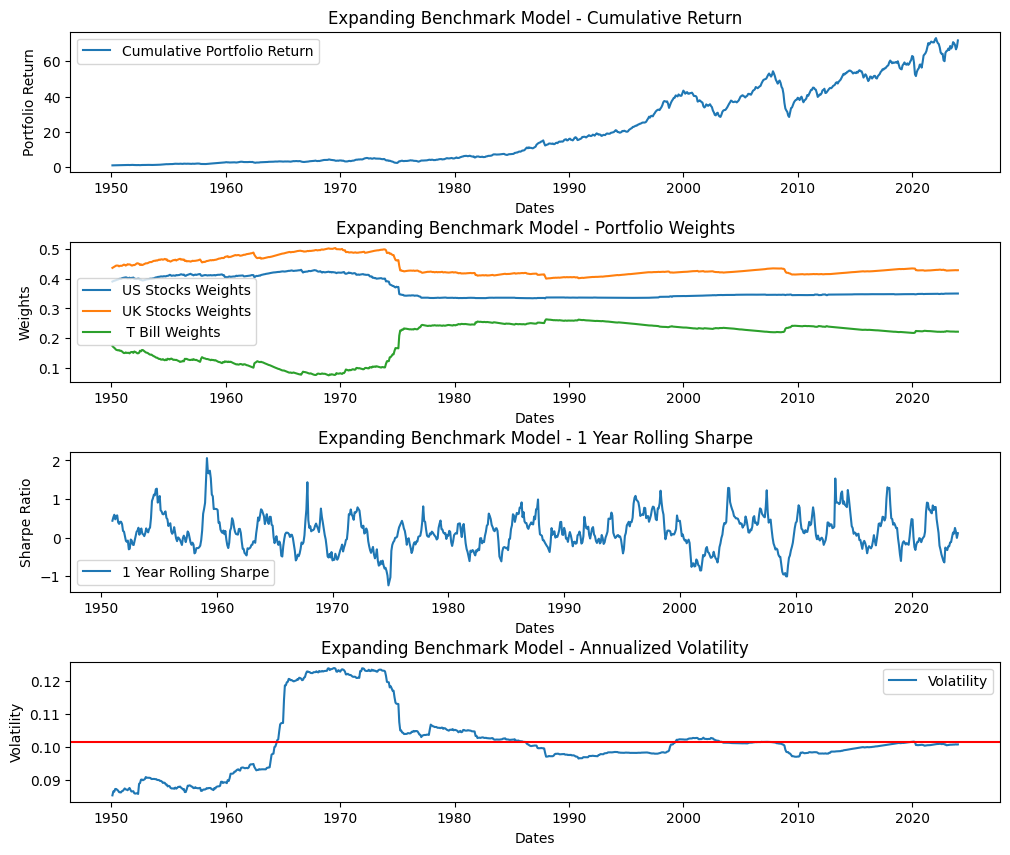

In [197]:
expanding_benchmark_portfolio = optimized_expanding_model_results(expanding_benchmark_prediction_US, expanding_benchmark_prediction_UK, expanding_benchmark_prediction_fx)
plot_portfolio_metrics(model=expanding_benchmark_portfolio, title="Expanding Benchmark Model")

## Expanding Competing Model

Annualized Portfolio Returns: 5.776978641624077 % 
Annualized Portfolio Volatility: 10.137589406511786 %
Annualized Sharpe Ratio: 0.6115876858198616
Annualized Sortino Ratio: 0.23056076353446842


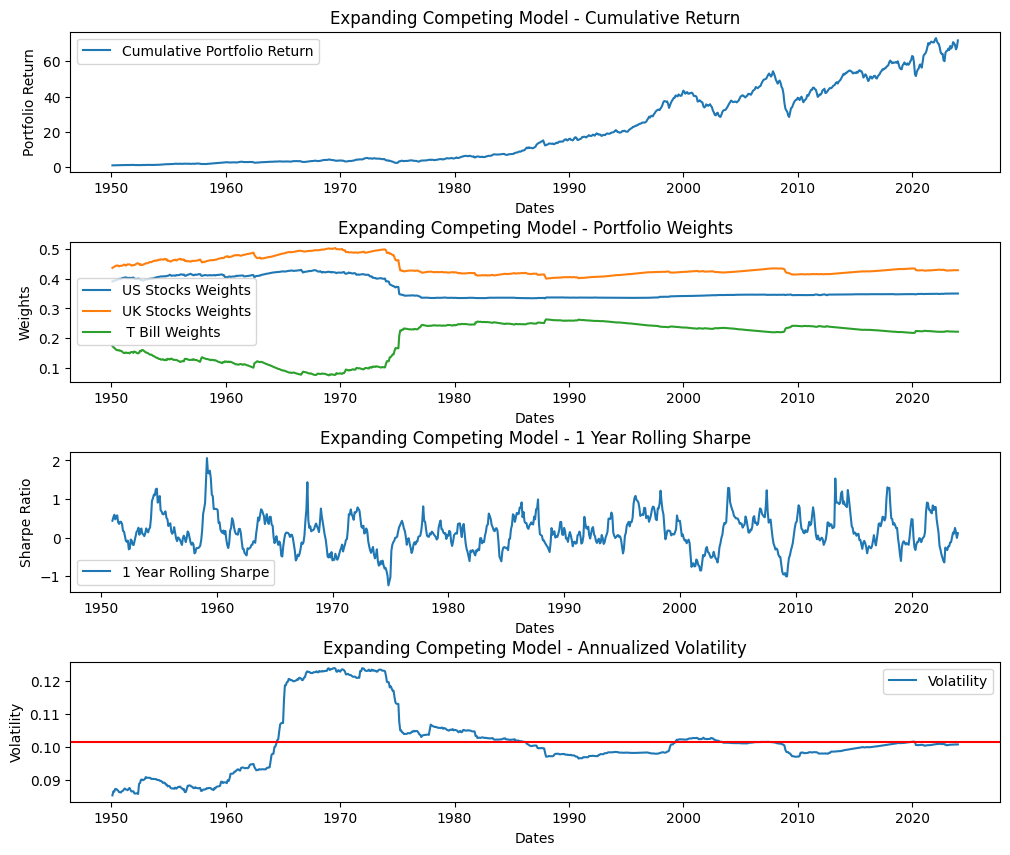

In [198]:
expanding_model_portfolio = optimized_expanding_model_results(expanding_model_prediction_US, expanding_model_prediction_UK, expanding_model_prediction_fx)
plot_portfolio_metrics(model=expanding_model_portfolio, title="Expanding Competing Model")

## Rolling Benchmark 

In [201]:
def optimized_rolling_model_results(us_model, uk_model, fx_model, target_vol=0.10):
    
    weights = np.zeros((len(us_model), 3))
    volatility = []
    realized_vol = []
    for i in range(0, len(us_model)):

        start = i
        end = 120 + i
        #Previous Implentation with Actual[:i] + Next Forecast Period
        return_matrix = pd.DataFrame(
            {
                'US Stock Returns' : np.array(us_data['Log Returns'][start : end]),
                'UK Stock Returns' : np.array(uk_data['Log Returns'][start : end] + uk_data['FX Returns'][start : end]),
                'Risk Free Returns' : np.array(us_data['Risk Free Returns'][start : end])
            }
        )
        
        new_row = [us_model[i], uk_model[i] + fx_model[i], None]
        return_matrix.loc[len(return_matrix)] = new_row
        return_matrix['Risk Free Returns'].fillna(method='ffill', inplace=True)

        cov_matrix = return_matrix.cov() #* 12 # annualize?
        current_weights = target_volatility_optimization(cov_matrix=cov_matrix, target_annual_vol=target_vol)
        #print(weights)
        weights[i] = current_weights
        volatility.append(portfolio_volatility(current_weights, cov_matrix))
        realized_vol.append(portfolio_volatility(current_weights, actual_returns[:120 + i + 1].cov()))

    us_stocks_weights = weights[:, 0]
    uk_stocks_weights = weights[:, 1]
    t_bills_weights = weights[:, 2]

    assert weights.shape  == actual_returns.shape
    # Step 1: Calculate portfolio log returns for each period
    portfolio_log_returns = (weights * actual_returns.values).sum(axis=1)
    # Step 2: Convert log returns to simple returns
    portfolio_simple_returns = np.exp(portfolio_log_returns) - 1
    # Step 3: Compute cumulative portfolio value, assuming initial value is 100
    initial_value = 100
    cumulative_portfolio_return = np.cumprod(1 + portfolio_simple_returns)
    cumulative_portfolio_value = cumulative_portfolio_return * initial_value

    # Calculate Annualized Portfolio Return & Volatility
    annualized_portfolio_return = np.mean(portfolio_log_returns) * 12
    annualized_volatility = pd.Series(realized_vol) * np.sqrt(12)

    # calculate Sharpe
    monthly_excess_returns = pd.Series(portfolio_log_returns - actual_returns['Risk Free Rate'])
    rolling_mean_monthly_returns = monthly_excess_returns.rolling(window=12).mean()
    rolling_std_monthly = monthly_excess_returns.rolling(window=12).std()
    rolling_one_year_sharpe = rolling_mean_monthly_returns/rolling_std_monthly

    # calculate annualized sharpe
    annualized_sharpe = (monthly_excess_returns.mean()/monthly_excess_returns.std()) * 12

    # calculate annualized sortino
    negative_excess_returns = monthly_excess_returns[monthly_excess_returns < 0]
    annualized_sortino = (monthly_excess_returns.mean() * 12)/(negative_excess_returns.std() * np.sqrt(2))

    result = {
        'Weights' : weights,
        'Cumulative Portfolio Return': cumulative_portfolio_return,
        'Volatility' : volatility,
        'Realized Volatility': realized_vol,
        'Annualized Volatility': annualized_volatility,
        'US Stocks Weights' : us_stocks_weights,
        'UK Stocks Weights' : uk_stocks_weights,
        'T Bill Weights' : t_bills_weights,
        'Portfolio Log Returns': portfolio_log_returns,
        'Portfolio Simple Returns': portfolio_simple_returns,
        'Cumulative Portfolio Value' : cumulative_portfolio_value,
        'Annualized Portfolio Return': annualized_portfolio_return,
        '1 Year Rolling Sharpe': rolling_one_year_sharpe,
        'Annualized Sharpe Ratio': annualized_sharpe,
        'Annualized Sortino Ratio': annualized_sortino
    }
    
    print(f"Annualized Portfolio Returns: , {annualized_portfolio_return * 100} % ")
    print(f"Annualized Portfolio Volatility: {np.mean(annualized_volatility) * 100} %")
    print(f"Annualized Sharpe Ratio: {annualized_sharpe}")
    print(f"Annualized Sortino Ratio: {annualized_sortino}")

    return result

Annualized Portfolio Returns: , 5.528868050804911 % 
Annualized Portfolio Volatility: 10.368668016238198 %
Annualized Sharpe Ratio: 0.5221485540375154
Annualized Sortino Ratio: 0.4692273468207745


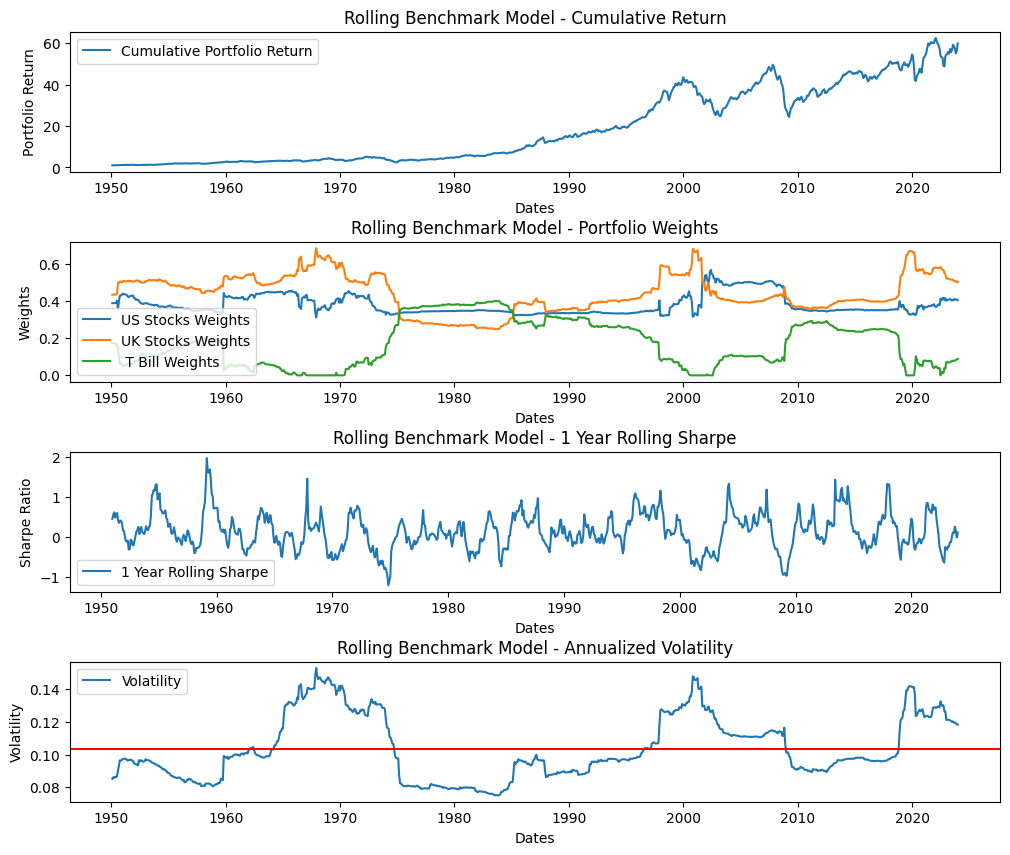

In [202]:
rolling_benchmark_portfolio = optimized_rolling_model_results(rolling_benchmark_prediction_US, rolling_benchmark_prediction_UK, rolling_benchmark_prediction_fx)
plot_portfolio_metrics(model=rolling_benchmark_portfolio, title="Rolling Benchmark Model")

## Rolling Model

Annualized Portfolio Returns: , 5.529710737975197 % 
Annualized Portfolio Volatility: 10.369458039975102 %
Annualized Sharpe Ratio: 0.5223795219646068
Annualized Sortino Ratio: 0.46945429071069805


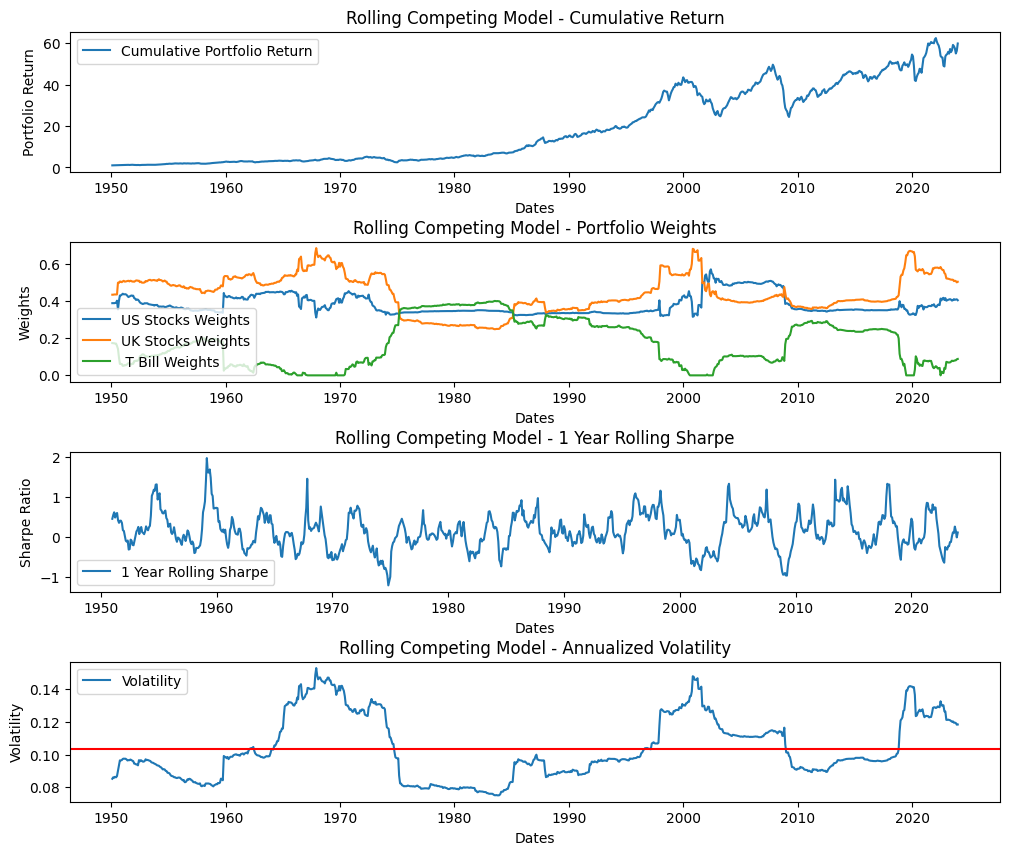

In [203]:
rolling_model_portfolio = optimized_rolling_model_results(rolling_model_prediction_US, rolling_model_prediction_UK, rolling_model_prediction_fx)
plot_portfolio_metrics(model=rolling_model_portfolio, title="Rolling Competing Model")